## Boston housing
Dans cet exercice, vous devez implémenter un modèle graphique de régression linéaire dans tensorflow. Le modèle devra être régularisé par la méthode de Ridge-Lasso, c'est à dire que la solution devra minimiser les normes L2 et L1 des paramètres du modèle.

Note: Ré-utilisez le codes des notebooks précédents et modifiez la fonction de coût! 

Description des données:
Ces données font à l'origine partie du [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). Elles ont été collecté en 1978 et les 506 lignes du jeu de données représentent les informations agrégées des banlieues de Boston. Le but de l'exercice est de prédire la prix d'une maison à partir d'un certain nombre de variables quantitatives (taux de criminalité, contamination à l'oxyde d'azote, etc.)

Votre objectif sera d'obtenir une erreur de prédiction minimale

- sélection de variables
- construction du graphe en fonction des variables sélectionnées
- définir l'erreur de type lasso
- modifier l'entrainement pour un critère de convergence
- monitorer l'erreur de test pour chaque batch d'entrainement


## 1) Importer les données

In [1]:
# Libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
brutes = load_boston()
data = brutes['data']
Y = brutes['target']

# Success
print("Ce jeu de données possède {} points avec {} variables chacun.".format(*data.shape))


Ce jeu de données possède 506 points avec 13 variables chacun.


Text(0, 0.5, 'Prix des maisons')

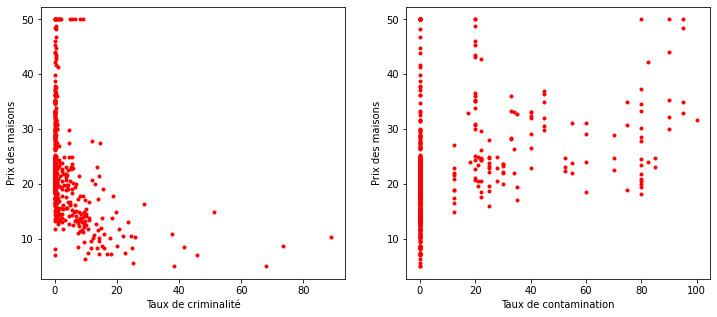

In [2]:
# Visualiser les données
hF = plt.figure(figsize=[12,5])
Ax1 = plt.subplot(121)
Ax1.plot(data[:,0], Y, '.r')
Ax1.set_xlabel('Taux de criminalité')
Ax1.set_ylabel('Prix des maisons')
Ax2 = plt.subplot(122)
Ax2.plot(data[:,1], Y, '.r')
Ax2.set_xlabel('Taux de contamination')
Ax2.set_ylabel('Prix des maisons')


In [3]:
print(data.shape)
print(Y.shape)

(506, 13)
(506,)


In [4]:
df = pd.DataFrame(data, columns = brutes.feature_names)

df["PRIX"] = brutes.target
df.head()
print(pd.isnull(df).any())


CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
PRIX       False
dtype: bool


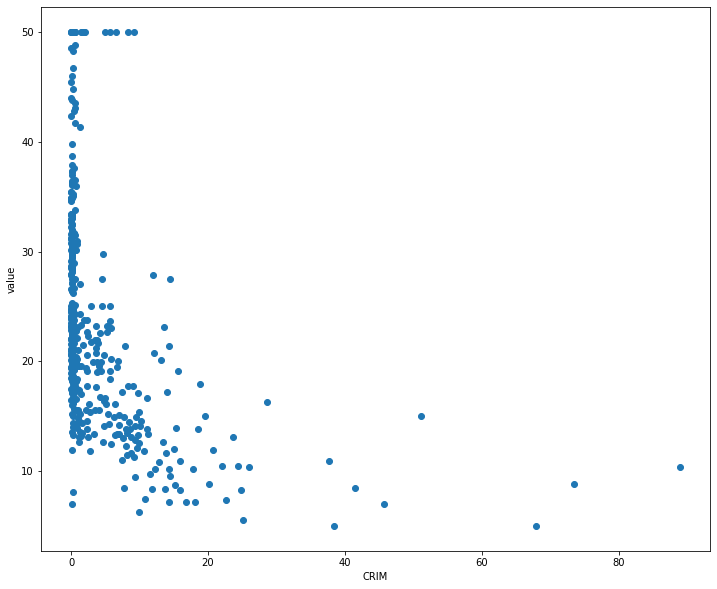

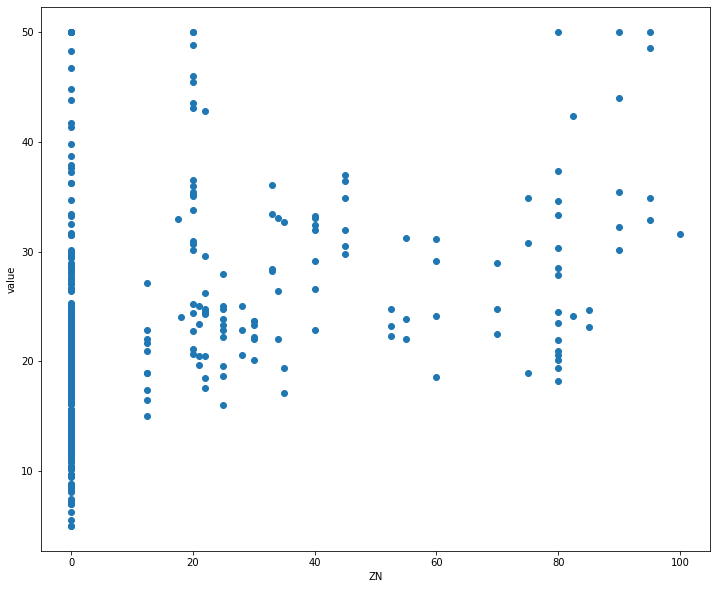

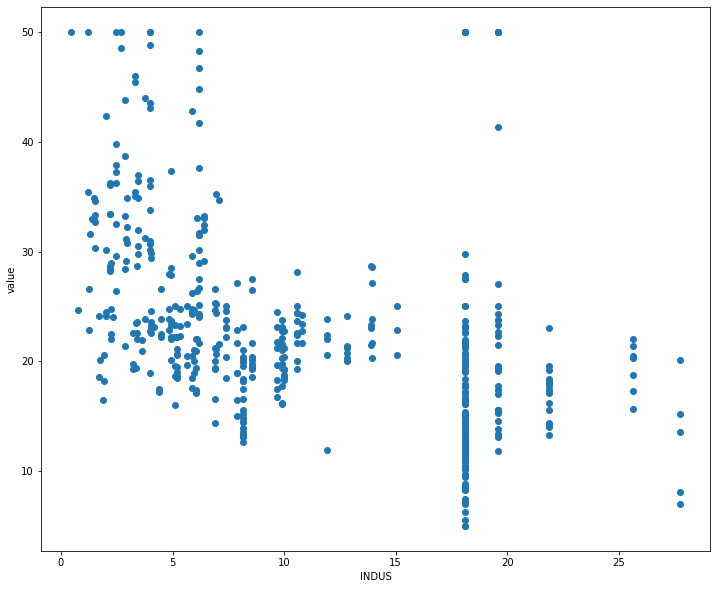

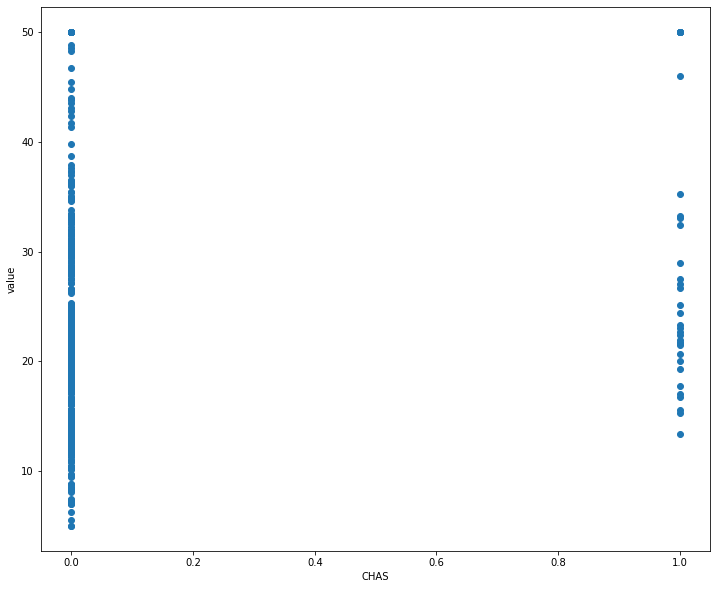

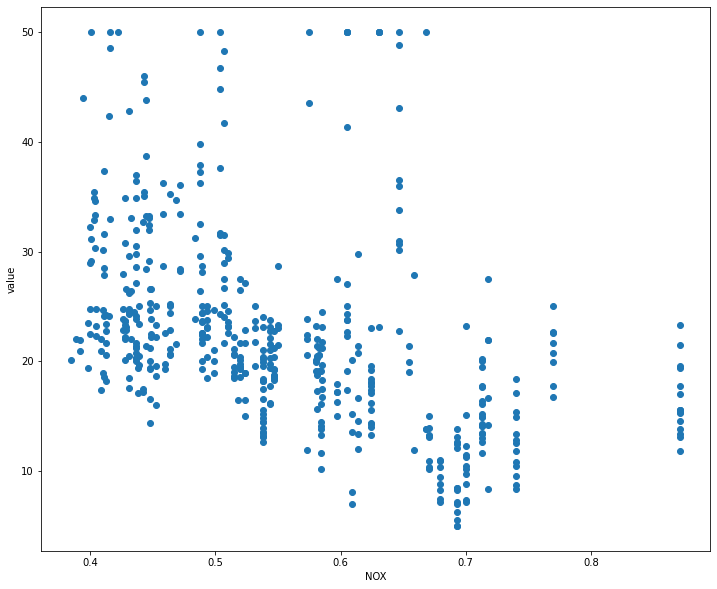

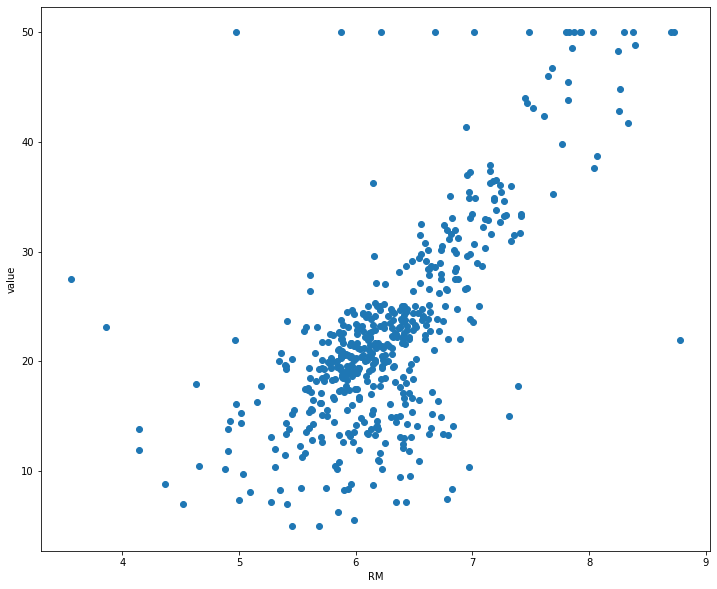

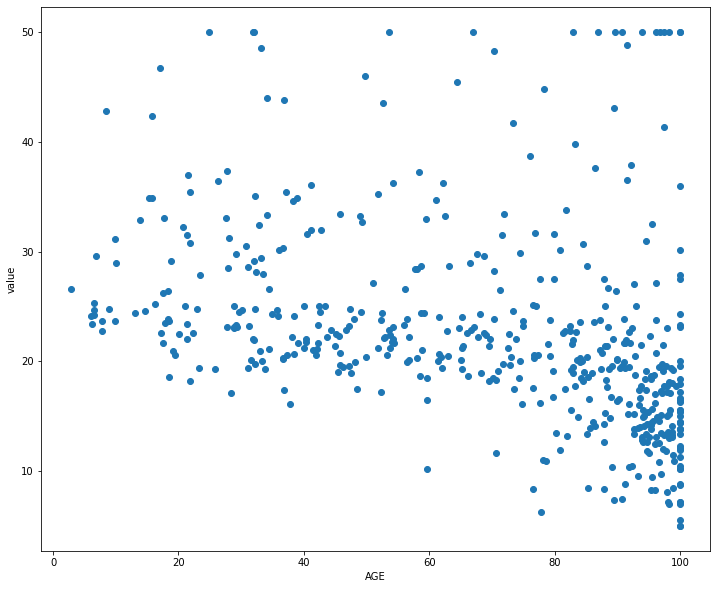

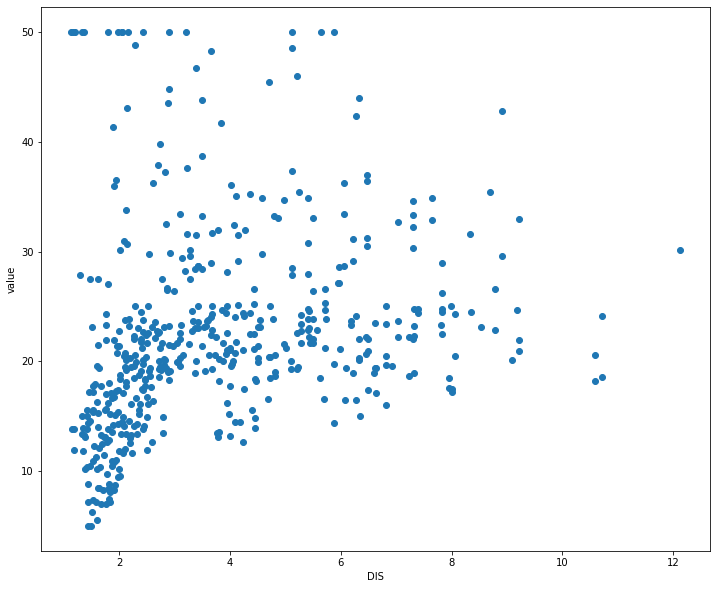

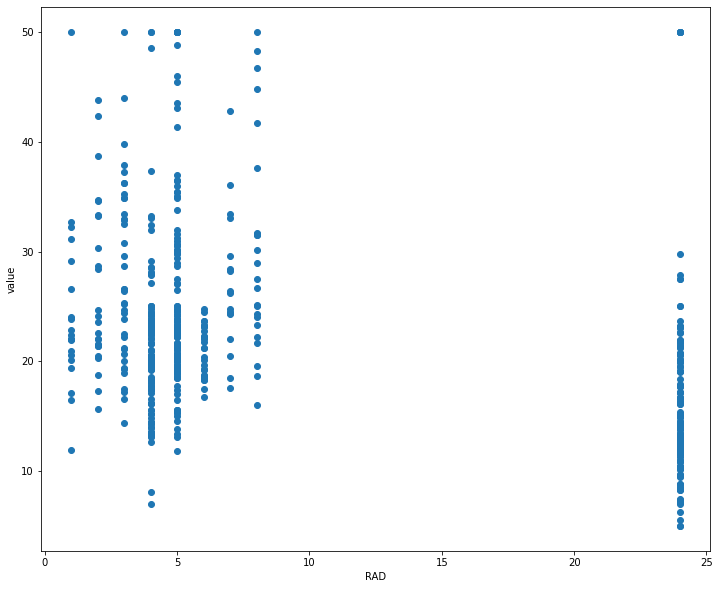

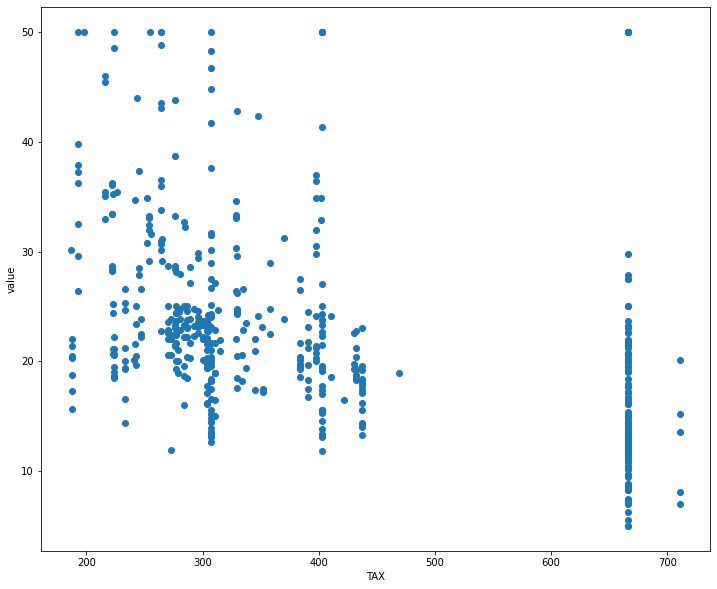

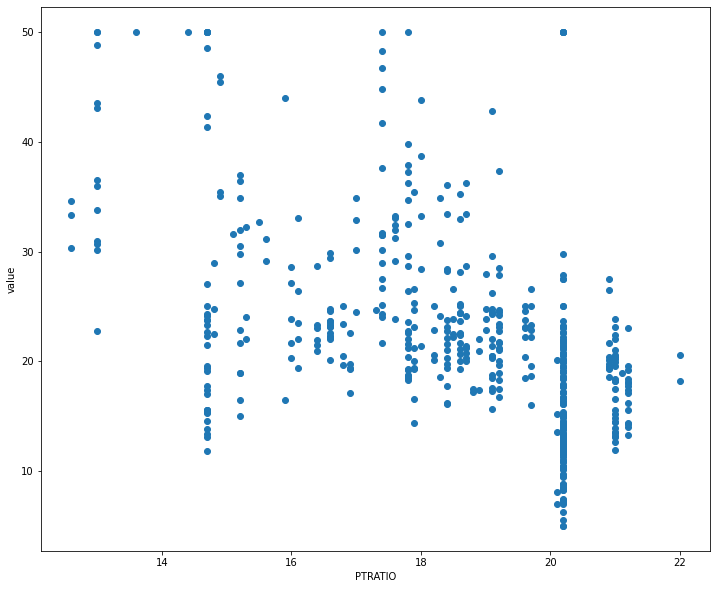

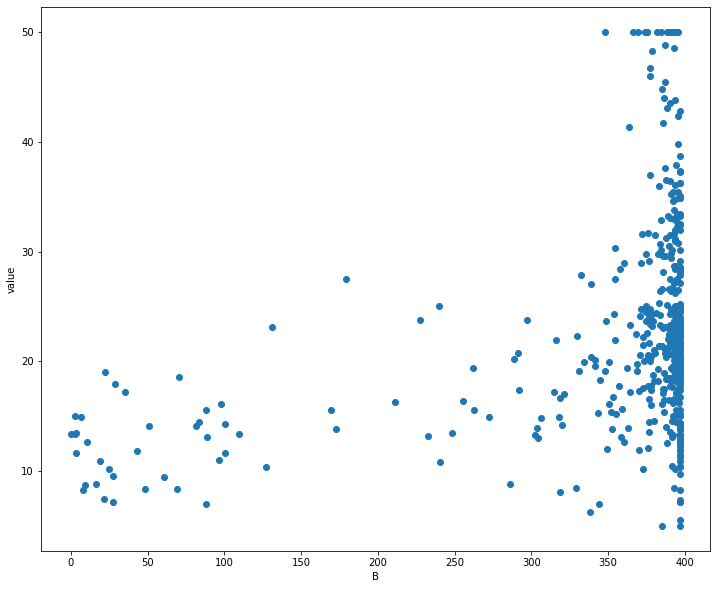

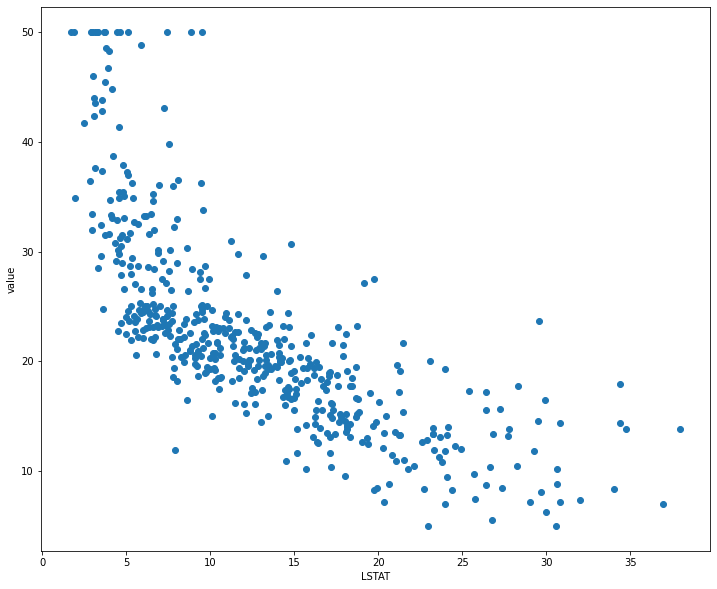

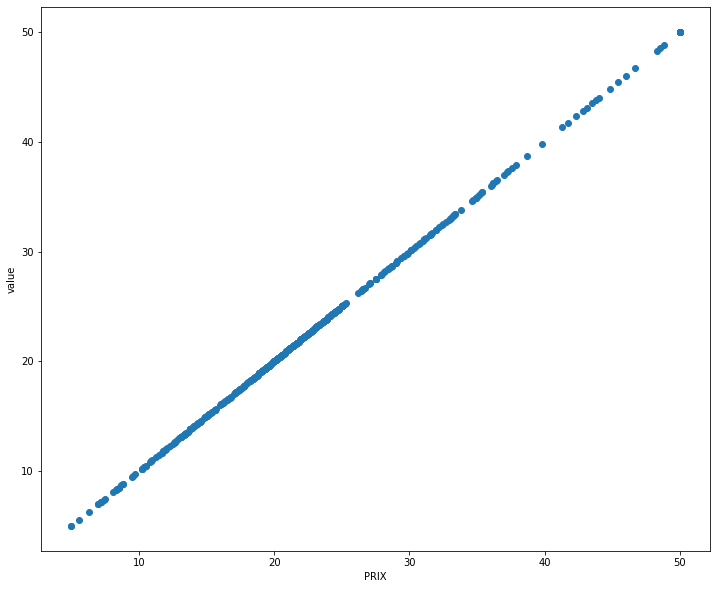

In [5]:
for c in df.columns:
    plt.figure(figsize=(12,10))
    plt.xlabel(c)
    plt.ylabel("value")
    plt.scatter(x=df[c],y=Y)
   
    plt.show()

C:\Users\Gus\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


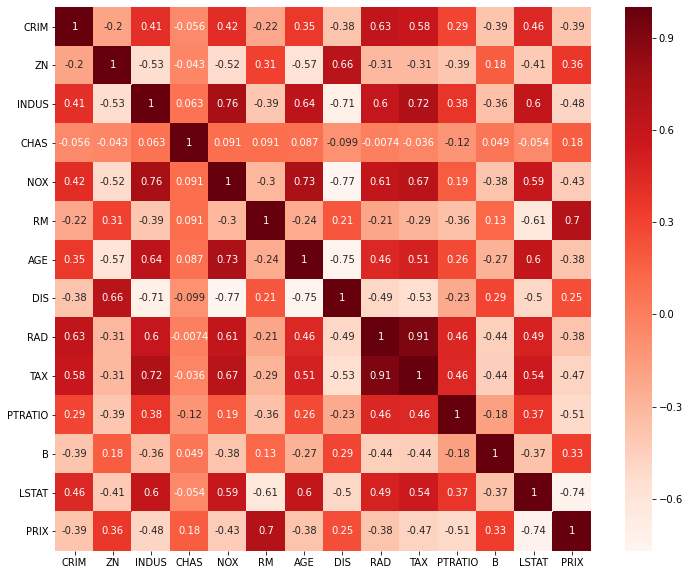

In [6]:
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

* RM and LSTAT sont fortement correlées on choisi LSTAT pour la correlation plus fort avec la cible
* NOX et DIS sont fortement correlées on choisi NOX pour avoir une correlation plis fort avec la cible

In [7]:
df.drop(["RM","DIS"],axis=1,inplace=True)


* on check la contribuition à la qualité du modèle de chaque variable

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
def create_pipe(c):
  
   preprocessor = ColumnTransformer(
    transformers=[
        ('preprocessing', StandardScaler(), c)])
   pipe = Pipeline(steps=[('preprocessing',preprocessor),("model",LinearRegression())])
   return pipe

In [9]:
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]],df[df.columns[-1]], test_size = 0.2, random_state = 0)
colonnes = list(df.columns[:-1])
pipe = create_pipe(colonnes)
pipe.fit(X_train[colonnes],y_train)
y_pred = pipe.predict(X_test[colonnes])
s = pipe.score(X_test[colonnes],y_test)
print("Score avec tous les colonnes:{}".format(pipe.score(X_test[colonnes],y_test)))
scores=[]
removed=[]
for remove in df.columns[:-1]:
     
     colonnes = list(df.columns[:-1])
     colonnes.remove(remove)
     pipe = create_pipe(colonnes)
     pipe.fit(X_train[colonnes],y_train)
     y_pred = pipe.predict(X_test[colonnes])
     
     scores.append(pipe.score(X_test[colonnes],y_test))
     if pipe.score(X_test[colonnes],y_test) > s:
            df.drop([remove],axis=1,inplace=True)
            #print("Colonne {} enlevé".format(remove))
            removed += [remove]
     print("Score:{} sans {}".format(pipe.score(X_test[colonnes],y_test),remove))
scores =np.array(scores)        
scores_ = scores>s
print("colonnes:{} on étés supprimées".format(removed))

Score avec tous les colonnes:0.46558830122344774
Score:0.4585712357773094 sans CRIM
Score:0.4682367589060208 sans ZN
Score:0.46657716382532155 sans INDUS
Score:0.4585036854175041 sans CHAS
Score:0.4520015157527548 sans NOX
Score:0.43332681189443045 sans AGE
Score:0.41390836106687645 sans RAD
Score:0.44960322510145645 sans TAX
Score:0.47118138595225734 sans PTRATIO
Score:0.4652274402809433 sans B
Score:0.14877242472574492 sans LSTAT
colonnes:['ZN', 'INDUS', 'PTRATIO'] on étés supprimées


 J'ai calculé l'accuracy en supprimant une variable à la fois si le score est plus petit que le score avec toutes les variable je suprimme le variable en question.

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('preprocessing', StandardScaler(), df.columns[:-1])])
pipe = Pipeline(steps=[('preprocessing',preprocessor)])


In [11]:
selected_features_rfe = df.columns[:-1]


In [12]:
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing  import StandardScaler
scaler = StandardScaler()

##scaled=scaler.fit_transform(df)
df = pd.DataFrame(preprocessor.fit_transform(df),index=df.index, columns=df.columns[:-1])
df["PRIX"] = brutes["target"]
X_train,X_test,Y_train,Y_test = train_test_split(df[selected_features_rfe],Y,test_size=0.2)
df

,CRIM,CHAS,NOX,AGE,RAD,TAX,B,LSTAT,PRIX
0,-0.419782,-0.272599,-0.144217,-0.120013,-0.982843,-0.666608,0.441052,-1.075562,24.0
1,-0.417339,-0.272599,-0.740262,0.367166,-0.867883,-0.987329,0.441052,-0.492439,21.6
2,-0.417342,-0.272599,-0.740262,-0.265812,-0.867883,-0.987329,0.396427,-1.208727,34.7
3,-0.416750,-0.272599,-0.835284,-0.809889,-0.752922,-1.106115,0.416163,-1.361517,33.4
4,-0.412482,-0.272599,-0.835284,-0.511180,-0.752922,-1.106115,0.441052,-1.026501,36.2
...,...,...,...,...,...,...,...,...,...
501,-0.413229,-0.272599,0.158124,0.018673,-0.982843,-0.803212,0.387217,-0.418147,22.4
502,-0.415249,-0.272599,0.158124,0.288933,-0.982843,-0.803212,0.441052,-0.500850,20.6
503,-0.413447,-0.272599,0.158124,0.797449,-0.982843,-0.803212,0.441052,-0.983048,23.9
504,-0.407764,-0.272599,0.158124,0.736996,-0.982843,-0.803212,0.403225,-0.865302,22.0


* y = b0 + b1\*CRIM + b2\*ZN + b3\*INDUS + b4\*CHAS + b5\*NOX + b6\*RM + b7\*RAD + b8\*PTRATIO + b9\*LSTAT + b10*DIS

In [13]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# On déclare les variables d'entree et de sortie comme des placeholders
# La 1ère dimension est de taille inconnue
# La seconde dimension correspond au nombre de variables (et non d'observations!) en entrée
n_variables = X_train.shape[1]
n_sorties = 1
X = tf.placeholder("float", [None, n_variables])
S =  tf.placeholder(tf.float32,[None,1])

Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
nb_points = len(X_train)
taille_batch = 100

In [15]:

poids_0 = tf.Variable(tf.random_normal([n_variables,1]))
biais_0 = tf.Variable(tf.random_normal([1]))


poids_2 = tf.Variable(tf.random_normal([1, 1]))
biais_2 = tf.Variable(tf.random_normal([1]))

In [16]:
lasso_param = tf.constant(0.1)
Y = tf.add( tf.matmul(X, poids_0), biais_0 )
W = tf.add( tf.matmul(Y, poids_2), biais_2)


In [17]:
regularization_param_0 = tf.multiply(lasso_param,poids_0)
regularization_param_2 = tf.multiply(lasso_param,poids_2)

fcn_cout =tf.reduce_mean(tf.add(tf.add(tf.transpose(tf.square( S-W)),regularization_param_0),regularization_param_2))
taux_apprentissage = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate=taux_apprentissage)
train_op = optimizer.minimize(fcn_cout)
# Initialisation des variables
init = tf.global_variables_initializer()

In [18]:

nb_points = X_train.shape[0]
taille_batch = 20

iteration:1 cout=1.3967528390412283
Cout test: 525.208
iteration:2 cout=1.1115500572884436
Cout test: 499.19638
iteration:3 cout=0.9677929264484065
Cout test: 470.7479
iteration:4 cout=1.2516190934889386
Cout test: 438.78754
iteration:5 cout=1.1862679660910427
Cout test: 407.4015
iteration:6 cout=0.8251203782487624
Cout test: 378.26773
iteration:7 cout=0.775295597491878
Cout test: 346.9495
iteration:8 cout=0.7545010406191986
Cout test: 308.85565
iteration:9 cout=0.7620706841497138
Cout test: 271.19693
iteration:10 cout=0.43416459489576886
Cout test: 234.63008
iteration:11 cout=0.5740085261883122
Cout test: 198.50531
iteration:12 cout=0.200338344762821
Cout test: 172.54066
iteration:13 cout=0.31145058055915453
Cout test: 153.06915
iteration:14 cout=0.23426567681945196
Cout test: 124.24697
iteration:15 cout=0.24574729239586557
Cout test: 99.31807
iteration:16 cout=0.24367521304895381
Cout test: 82.22521
iteration:17 cout=0.1373980399405602
Cout test: 71.90347
iteration:18 cout=0.13491378

iteration:14 cout=0.04855927382365312
Cout test: 38.447613
iteration:15 cout=0.08440725874192644
Cout test: 35.948463
iteration:16 cout=0.11033602988365854
Cout test: 45.1592
iteration:17 cout=0.07439262560098478
Cout test: 45.153046
iteration:18 cout=0.08436040595026299
Cout test: 44.776596
iteration:19 cout=0.16040335551346882
Cout test: 36.280987
iteration:1 cout=0.051759356319314186
Cout test: 36.360947
iteration:2 cout=0.08625341169904954
Cout test: 37.688698
iteration:3 cout=0.03932818091741883
Cout test: 37.078907
iteration:4 cout=0.08219549915578106
Cout test: 36.0535
iteration:5 cout=0.0894193177175994
Cout test: 35.461475
iteration:6 cout=0.060729994632229944
Cout test: 35.90639
iteration:7 cout=0.07425215220687413
Cout test: 40.68837
iteration:8 cout=0.07126504123801052
Cout test: 35.785503
iteration:9 cout=0.1387828222595819
Cout test: 35.244274
iteration:10 cout=0.037430369027770395
Cout test: 36.465664
iteration:11 cout=0.10900098970620939
Cout test: 35.20126
iteration:12

iteration:5 cout=0.09072129089053314
Cout test: 35.8177
iteration:6 cout=0.05988837232684145
Cout test: 35.418644
iteration:7 cout=0.07422500553697643
Cout test: 38.9284
iteration:8 cout=0.07214501824709449
Cout test: 36.310627
iteration:9 cout=0.13875476912696763
Cout test: 35.675507
iteration:10 cout=0.036546329460521734
Cout test: 36.162968
iteration:11 cout=0.11017689846529818
Cout test: 34.926823
iteration:12 cout=0.047920925782458615
Cout test: 39.50125
iteration:13 cout=0.0898115611312413
Cout test: 40.62519
iteration:14 cout=0.04916307241609781
Cout test: 37.787666
iteration:15 cout=0.08653657743246249
Cout test: 35.336742
iteration:16 cout=0.11112937360706895
Cout test: 42.13603
iteration:17 cout=0.07551389637559948
Cout test: 44.119736
iteration:18 cout=0.08348028730637956
Cout test: 43.894398
iteration:19 cout=0.16017428483113205
Cout test: 35.912457
iteration:1 cout=0.051343738442600366
Cout test: 36.30448
iteration:2 cout=0.08705873772649482
Cout test: 36.429432
iteration:

iteration:18 cout=0.08286141877127166
Cout test: 43.567173
iteration:19 cout=0.160656201957476
Cout test: 35.7113
iteration:1 cout=0.05092667116977201
Cout test: 36.10749
iteration:2 cout=0.08759071803329015
Cout test: 35.73962
iteration:3 cout=0.04142051640123424
Cout test: 36.730083
iteration:4 cout=0.08092440236913095
Cout test: 34.661755
iteration:5 cout=0.09164960313551497
Cout test: 35.911995
iteration:6 cout=0.059298741935503364
Cout test: 35.15649
iteration:7 cout=0.07517991679729802
Cout test: 37.349792
iteration:8 cout=0.07257150895524733
Cout test: 36.4824
iteration:9 cout=0.13850744644013963
Cout test: 35.83379
iteration:10 cout=0.03618939796296677
Cout test: 35.776237
iteration:11 cout=0.11136852868712775
Cout test: 34.765087
iteration:12 cout=0.04796148054670579
Cout test: 39.401165
iteration:13 cout=0.08974474727517308
Cout test: 39.57318
iteration:14 cout=0.04956466372650448
Cout test: 37.47536
iteration:15 cout=0.0884157407401812
Cout test: 34.954967
iteration:16 cout=

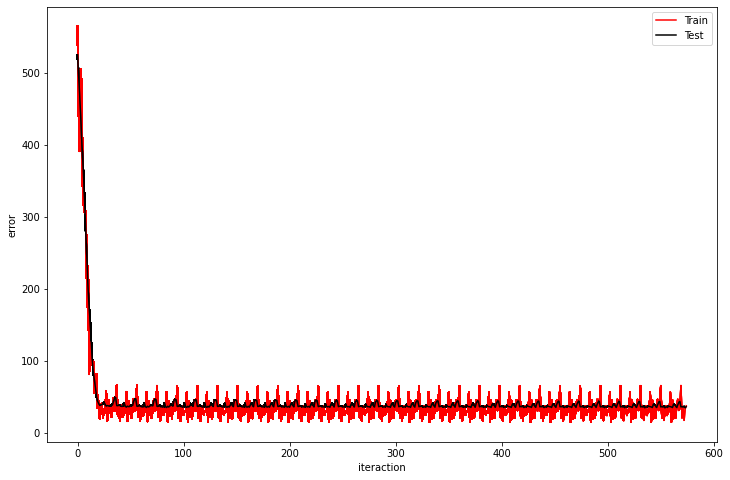

In [19]:
min_error = 0.0001
current_error = 10e4
pas_affichage = 10
error_train =[]
error_test=[]
with tf.Session() as sess:
  # 1ere operation executée: initialiser des variables
    # Durant la construction du graphe, nous avons spécifié des valeurs aléatoires
    sess.run(init)
    nb_batches = int(nb_points/taille_batch)
    i =0
    cout_moyen = 0
    stop = False
    plt.figure(figsize=(12,8))
    while not stop:
        for iter in range( 1,nb_batches)   :
            if stop :
                break
            for i in range(1,taille_batch) :
                _, c = sess.run([train_op, fcn_cout], feed_dict={X: X_train[iter*taille_batch:(iter+1)*taille_batch], S: np.reshape(Y_train[iter*taille_batch:(iter+1)*taille_batch], [-1,1])})
                #error_train += [c]
                    # Compute average loss
                i=i+1
                if np.abs(current_error - c )< min_error:
                    stop = True
                current_error = c
            cout_moyen = current_error/nb_points
            print("iteration:{} cout={}".format(iter,cout_moyen))
            cout_test = sess.run(fcn_cout, feed_dict={X:X_test, S:np.reshape(Y_test, [-1,1])})
            error_test += [cout_test]
            print("Cout test:", cout_test)
            #
            error_train +=[current_error]
            train, = plt.plot(list(range(len(error_train))), error_train, 'r')

            test, = plt.plot(list(range(len(error_test))), error_test, 'k')
    print("Optimisation reussie!")
    train.set_label('Train')
    test.set_label('Test')
    plt.xlabel("iteraction")
    plt.ylabel("error")
    plt.legend()
    plt.show()


  

      